In [14]:
import re 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
import sklearn

%matplotlib inline

stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/sxia1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# clean up data and tokenize text
### personality data (ignore)

805
641
['Inventive and Curious' 'Consistent and Cautions'
 'Efficient/Organised and Planned' 'Easygoing/Careless and Spontaneous'
 'Outgoing and Energetic' 'Solidatory and Reserved'
 'Friendly and Compassionate' 'Cold and Unkind' 'Sensitive and Nervous'
 'Secure and Confident' 'Not_Well' 'Others']


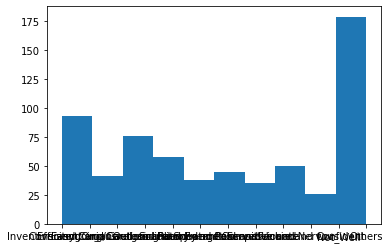

text             innovators are scientists looking for the best...
personalities                                Inventive and Curious
Name: 1, dtype: object
['innovators', 'are', 'scientists', 'looking', 'for', 'the', 'best', 'possible', 'solutions']


/tmp/ipykernel_624/2654732793.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_words']=list(map(lambda x:len(x),text_tokenized))


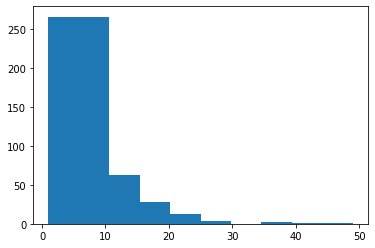

In [149]:
# read-in pre-labled tweets
df_raw = pd.read_excel("data/corpus_new.xlsx",sheet_name="Sheet1",names=["text","personalities"])
print(len(df_raw))
#skip non-english text
df = df_raw[df_raw['text'].apply(lambda x:x.isascii())]
print(len(df))
print(df.personalities.unique())
plt.hist(df['personalities'])
plt.show()
# tokenize each text
text_tokenized = list(map(lambda news:nltk.word_tokenize(news.lower()), df['text']))
len(text_tokenized)
print(df.iloc[0])
print(text_tokenized[0])
df['n_words']=list(map(lambda x:len(x),text_tokenized))
plt.hist(df.n_words)
plt.show()

## Web of science paper data

46985
['CS ' 'Medical ' 'Civil ' 'ECE ' 'biochemistry ' 'MAE ' 'Psychology  ']


/tmp/ipykernel_18036/4036168791.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper['n_words']=list(map(lambda x:len(x),text_tokenized))


Text(0.5, 1.0, 'abstract word count')

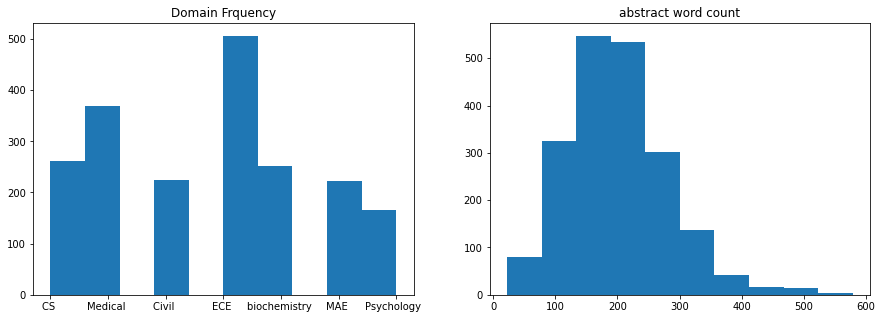

In [4]:
# read-in pre-labled research apper abstracts
df_paper_raw = pd.read_excel("data/WebOfScienceData.xlsx",sheet_name="abstracts")
print(len(df_paper_raw))
df_paper = df_paper_raw.head(2000)
print(df_paper.Domain.unique())

# tokenize each text
text_tokenized = list(map(lambda news:nltk.word_tokenize(news.lower()), df_paper['Abstract']))
len(text_tokenized)
df_paper['n_words']=list(map(lambda x:len(x),text_tokenized))

fig,axs = plt.subplots(1,2,figsize=(15,5))
axs[0].hist(df_paper.Domain,)
axs[0].set_title("Domain Frquency")
axs[1].hist(df_paper.n_words)
axs[1].set_title("abstract word count")

# remove stopwords, make biargam, lemmatize

/tmp/ipykernel_18036/3074456696.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper['n_words_removed']=list(map(lambda x:len(x),text_stopwords_removed))


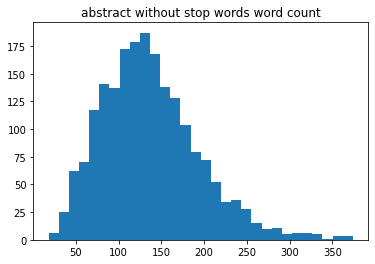

In [5]:
# remove stopwords
text_stopwords_removed = list(map(lambda abstract: list(filter(lambda word: word not in stop_words, abstract)),text_tokenized))
df_paper['n_words_removed']=list(map(lambda x:len(x),text_stopwords_removed))
plt.hist(df_paper.n_words_removed,bins=30)
plt.title("abstract without stop words word count")

# Creating Bigram: find words frequently occur together
bigram = gensim.models.Phrases(text_tokenized, min_count=20, threshold=50)  
#come back to adjust the threshold value: (cnt(a, b) - min_count) * N / (cnt(a) * cnt(b)) > threshold
bigram_freeze = bigram.freeze()
#apply biagra model
word_and_bigram_list = list(map(lambda abstract_cleaned: bigram[abstract_cleaned],text_stopwords_removed))

# lemmatize


In [15]:
lemmatizer = WordNetLemmatizer()

'bat'

In [24]:
nltk.pos_tag(word_and_bigram_list[1])


[('(', '('),
 ('beta-amyloid', 'NN'),
 ('(', '('),
 ('beta', 'NN'),
 (')', ')'),
 ('tau', 'NN'),
 ('pathology', 'NN'),
 ('become', 'VBP'),
 ('increasingly', 'RB'),
 ('prevalent', 'JJ'),
 ('age', 'NN'),
 (',', ','),
 ('however', 'RB'),
 (',', ','),
 ('spatial', 'JJ'),
 ('relationship', 'NN'),
 ('two', 'CD'),
 ('pathologies', 'NNS'),
 ('remains', 'VBZ'),
 ('unknown', 'JJ'),
 ('.', '.'),
 ('examined', 'VBN'),
 ('local', 'JJ'),
 ('(', '('),
 ('region', 'NN'),
 (')', ')'),
 ('non-local', 'JJ'),
 ('(', '('),
 ('different', 'JJ'),
 ('region', 'NN'),
 (')', ')'),
 ('associations', 'VBZ'),
 ('2', 'CD'),
 ('aggregated', 'JJ'),
 ('proteins', 'NNS'),
 ('46', 'CD'),
 ('normal', 'JJ'),
 ('older', 'JJR'),
 ('adults', 'NNS'),
 ('using', 'VBG'),
 ('[', 'JJ'),
 ('f-18', 'JJ'),
 (']', 'NN'),
 ('av-1451', 'NN'),
 ('(', '('),
 ('tau', 'NN'),
 (')', ')'),
 ('[', 'VBZ'),
 ('c-11', 'JJ'),
 (']', 'NNP'),
 ('pib', 'NN'),
 ('(', '('),
 ('beta', 'NN'),
 (')', ')'),
 ('positron', 'NN'),
 ('emission', 'NN'),
 ('tom